### Load Library and files

In [17]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import scipy 
import re

H5_FILE = "./DATA/vaspelph_path.h5"
OUTCAR_FILE = "./DATA/OUTCAR"

### check some dimensions
    From VASP WIKI: /matrix_elements/elph
    shape: {nspin, n_kp, n_k, 3*natoms, nBand_kp, nBand_k, 2}
    The last (fastest) dimension is due to complex numbers
    being stored as two real numbers (real and imaginary parts).
    n_kp and nBand_kp refer to the initial (Ket) state.
    n_k and nBand_k refer to the final (Bra) state.

In [18]:
f = h5py.File(H5_FILE, "r")
matrix = f["matrix_elements"]["elph"][:]
print("matrix, min= ",np.min(matrix)," max=",np.max(matrix))
print(matrix.shape)
print("band start kp:", f["matrix_elements"]["band_start_kp"][()])
print("band start k:", f["matrix_elements"]["band_start_k"][()])
band_start_k = f["matrix_elements"]["band_start_k"][()]
band_start_kp = f["matrix_elements"]["band_start_kp"][()]
nBand_k = matrix.shape[-2] #I look for the actual one, the one in matrix element
nBand_ph = matrix.shape[3]
nBand_kp = f["matrix_elements"]["nbands_kp"][()]

weights =  f["kpoints"]["wtkpt_k"]
print("unique weights= ",np.unique(weights))

phonon_eigen = np.array(f["matrix_elements"]["phonon_eigenvalues"][:])
print(phonon_eigen.shape)
print("phonon, min= ",np.min(phonon_eigen)," max=",np.max(phonon_eigen))

electron_eigen_FBZ = np.array(f["matrix_elements"]["eigenvalues_kp"][0,:,:]).T
print(electron_eigen_FBZ.shape)

electron_eigen_IBZ = np.array(f["matrix_elements"]["eigenvalues_k"][0,:,band_start_k-1: band_start_k-1+nBand_k]).T
print(electron_eigen_IBZ.shape)

mapFI = np.array(f["kpoints"]["indx_fbz2ibz"][:])


#vasp compute the weight by considering the uniform mesh and then the multiplicity of each k symmetry reduced
# if one perfor a calculation not sym reduced (ISYM = -1) the weight are uniform
"""multiplicity = np.zeros(72)
for i in mapFI:
    multiplicity[i-1]+=1
print(multiplicity)
myWeights = np.ones(72)/1728
myWeights = np.multiply(myWeights,multiplicity) """


kIBZ = np.array(f["kpoints"]["vkpt_k"][:])
kFBZ = np.array(f["kpoints"]["vkpt_kp"][:])
n_kp = f["matrix_elements"]["nkpts_kp"][()]
n_k = f["matrix_elements"]["nkpts_k"][()]

print(scipy.constants.hbar)

matrix, min=  -1.4552269307810268  max= 1.397338445044585
(1, 120, 120, 6, 10, 10, 2)
band start kp: 1
band start k: 1
unique weights=  [0.00833333]
(120, 120, 6)
phonon, min=  0.0  max= 94.65407107669365
(10, 120)
(10, 120)
1.0545718176461565e-34


## Simmetry
Check how simmetry Map works

In [19]:
mapIF = np.array(f["kpoints"]["irot_fbz2ibz"][:])
n_test = 10
sym = np.array(f["kpoints"]["igrpop"][:])
print(sym[2].dot(sym[2].T))
nsym = np.array(f["kpoints"]["nrotk"][()])
print(nsym)
sym_inv = [np.linalg.inv(sym[i]) for i in range(nsym)] 
for i in range(min(100, nsym)):
    R = sym_inv[mapIF[i] - 1]              # rotation bringing FBZ→IBZ
    k_ibz_calc = R.dot(kFBZ[i])        # mapped point
    k_ibz_ref = kIBZ[mapFI[i] - 1]     # reference IBZ point

 
    if(np.linalg.norm(k_ibz_calc -k_ibz_ref)<1e-6):
        continue
    else:
        print(f"{i}: FBZ {kFBZ[i]} → R[{mapIF[i]}] → {k_ibz_calc}, expected IBZ {k_ibz_ref}")

[[1 0 0]
 [0 1 0]
 [0 0 1]]
1


In [20]:

with open(OUTCAR_FILE, 'r') as f:
    for line in f:
        match = re.search(r'Fermi energy:\s+([-\d\.Ee]+)', line)
        if match:
            Ef = float(match.group(1))
            print(f"Ef= {Ef}eV")
            break

Ef= 5.8093647716eV


In [21]:
#Check if a point x is on the segment between P1 and P2
def isOnLine(P1, P2, x, tol=0):
    v = P2 - P1
    w = x - P1

    # Check collinearity via cross product
    if np.linalg.norm(np.cross(v, w)) > tol:
        return False

    # Project to parameter t
    t = np.dot(w, v) / np.dot(v, v)

    # Check if inside segment
    return -tol <= t <= 1 + tol

    
P1=np.array([0,0,0])
P2 = np.array([0.5,0.5,0.5])
x1 = P1
x2 = P2
x3 = np.array([0.25,0.25,0.25])
x4 = -x3
x5 = x3 + P2
x6 = np.array([0.4,0.4,0.5])
print(isOnLine(P1,P2,x6)) #counter example

False


### Plot Electron BandStructure

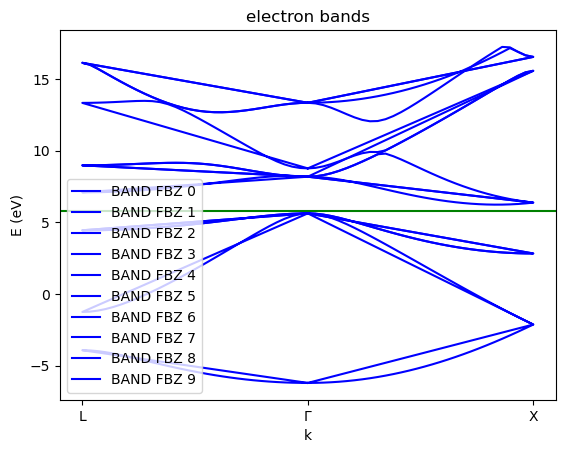

In [22]:
#plot electron eigenvalues
G = np.array([0,0,0]) #gamma 
L = np.array([0.5,0.5,0.5])
K = np.array([0.5, 0.0, 0.5])
GL_q = np.array([])
GK_q = np.array([])

tol = 1e-3
tol1 = 0.03
id_GL_FBZ = [i for i in range(len(kFBZ )) if isOnLine(G, L, kFBZ [i],tol)]
id_GL_IBZ = [i for i in range(len(kIBZ )) if isOnLine(G, L, kIBZ [i],tol1)]
id_GK_FBZ = [i for i in range(len(kFBZ )) if isOnLine(G, K, kFBZ [i],tol)]
id_GK_IBZ = [i for i in range(len(kIBZ )) if isOnLine(G, K, kIBZ [i],tol1)]

distances_GL_FBZ = np.array([- np.linalg.norm(q)/np.linalg.norm(L) for q in kFBZ [id_GL_FBZ] ])[::-1]
distances_GK_FBZ = [np.linalg.norm(q)/np.linalg.norm(K)  for q in kFBZ [id_GK_FBZ] ]
distances_GL_IBZ = np.array([- np.linalg.norm(q)/np.linalg.norm(L) for q in kIBZ [id_GL_IBZ] ])[::-1]
distances_GK_IBZ = [np.linalg.norm(q)/np.linalg.norm(K)  for q in kIBZ [id_GK_IBZ] ]

distances_FBZ = np.append(distances_GL_FBZ,distances_GK_FBZ)
distances_IBZ = np.append(distances_GL_IBZ,distances_GK_IBZ)

el_FBZf = np.array([np.append(electron_eigen_FBZ[i][id_GL_FBZ][::-1], electron_eigen_FBZ[i][id_GK_FBZ] ) for i in range(nBand_kp)])
el_IBZf = np.array([np.append(electron_eigen_IBZ[i][id_GL_IBZ][::-1], electron_eigen_IBZ[i][id_GK_IBZ] ) for i in range(nBand_k)])

plt.figure()
#for i in range(nBand_k):
#   plt.plot(distances_IBZ,el_IBZf[i],label = f"BAND IBZ {i}", color="red")
plt.axhline(Ef, color="green")
for i in range(nBand_kp):
    if(electron_eigen_FBZ[i][0]<=Ef):
        n_VB = i
        n_CB = i+1
    plt.plot(distances_FBZ,el_FBZf[i],label = f"BAND FBZ {i}", color="blue")

plt.xlabel("k")
plt.ylabel("E (eV)")
plt.title("electron bands")
plt.legend()
plt.xticks([0, -1, 1], ['Γ', 'L', 'X'])
plt.savefig("elctronBandLIMIT.png")
plt.show()

### Plot g matrix amplitude on phonons dispersion


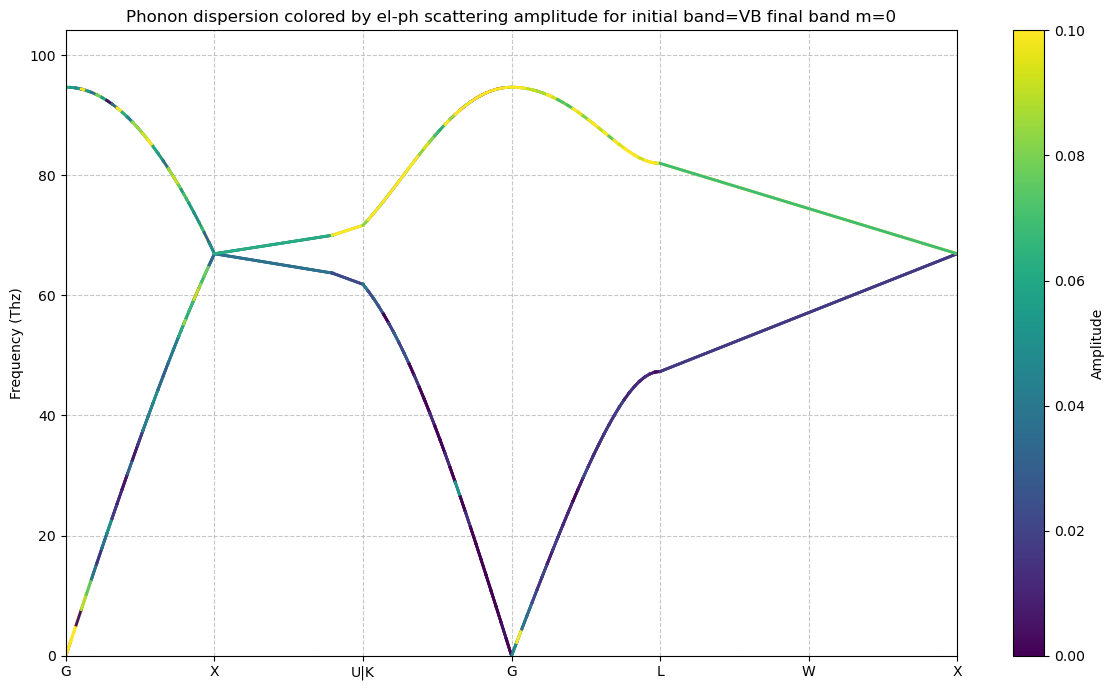

In [23]:
phonons = []
q = []
id_q = []
for i_kp in range(n_kp):
    for i_k in range(n_k):
            q.append(kIBZ[i_k] - kFBZ[i_kp])
            w = phonon_eigen[i_kp][i_k]
            phonon = {"q":q, "w":w, "i_k": i_k, "i_kp" : i_kp}
            phonons.append(phonon)


# Plot phonon dos along some path in the reciprocal space
G = np.array([0,0,0]) #gamma 
L = np.array([0.5,0.5,0.5])
X = np.array([0.5, 0.0, 0.5])
K = np.array([0.375, 0.3750, 0.75])
U = np.array([0.625, 0.250, 0.625])
W = np.array([ 0.5000000000,0.2500000000,0.7500000000])
path = np.array([[G,X],[X,U],[K,G],[G,L],[L,W],[W,X]])
#path = np.array([[L,G],[G,X],[X,U],[K,G]])
x = []
eigen = np.empty((nBand_ph,0))
amplitude = np.empty((nBand_ph,nBand_k,0))
delta = 0
n_vb = 3
for start,end in path:
    #normalize by end,start distance in the current line
     dist = np.linalg.norm(end - start) 
     for i_kp in range(n_kp):
          for i_k in range(n_k): 
               q = kIBZ[i_k] - kFBZ[i_kp]
               if isOnLine(start, end, q):
                    x.append(np.linalg.norm(q-start)/dist + delta )
                    eigen = np.hstack((eigen,phonon_eigen[i_kp][i_k][:].reshape(-1,1)))
                    g = matrix[0,i_kp,i_k,:,n_vb,:,0] + matrix[0,i_kp,i_k,:,n_vb,:,1]*1J
                    amplitude = np.concatenate((amplitude, np.abs(g)[:, :, np.newaxis]), axis=2)
     delta += 1

import matplotlib.cm as cm # Still needed for colormaps

x = np.array(x)
id = np.argsort(x)

# Sort x, eigen, and amplitude using these indices
x_sorted = x[id]
eigen_sorted = eigen[:, id]
amplitude_sorted = amplitude[:, :, id]

#  colormap
cmap = cm.viridis 

# Define xticks labels and positions 
path = np.array([[G,X],[X,U],[K,G],[G,L],[L,W],[W,X]])
xticks_labels = ['G', 'X','U|K','G','L','W','X']
xticks_positions = [0,1,2,3,4,5,6]

# Determine global min/max amplitude for consistent color scaling across ALL plots
# This ensures that a specific color represents the same amplitude value regardless of 'm'.
global_amplitude_min = np.min(amplitude_sorted)
global_amplitude_max = np.max(amplitude_sorted)

# Loop through each 'm' scenario to create separate plots -> to avoid huge number just plot firs bands
for m in range(1):
    fig, ax = plt.subplots(figsize=(12, 7)) # Create a new figure and axes for each 'm'
    amplitude_min_m = 0 
    amplitude_max_m = 0.1
    for v in range(nBand_ph): # Loop through each phonon band
        # Iterate through segments for each band
        for i in range(len(x_sorted) - 1):
            # Get the amplitude value for this segment (e.g., average of start and end points)
            segment_amplitude = (amplitude_sorted[ v,m, i] + amplitude_sorted[ v,m, i+1]) / 2

            # Normalize amplitude to [0, 1] range using global min/max
            normalized_amplitude = (segment_amplitude - amplitude_min_m) / \
                       (amplitude_max_m - amplitude_min_m)
            normalized_amplitude = np.clip(normalized_amplitude, 0, 1)
            # Get the color from the colormap
            segment_color = cmap(normalized_amplitude)
            # Plot the small segment using plt.plot
            ax.plot(x_sorted[i:i+2], eigen_sorted[v, i:i+2], color=segment_color, linewidth=2)

    # Add a dummy ScalarMappable to create a colorbar
    sm = cm.ScalarMappable(cmap=cmap)
    sm.set_array([amplitude_min_m, amplitude_max_m]) # Set min/max for the colorbar scale
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Amplitude")
    ax.set_xlim(x_sorted.min(), x_sorted.max())
    ax.set_ylim(eigen_sorted.min() * 0.9, eigen_sorted.max() * 1.1) # Add some padding to Y-axis
    ax.set_title(f"Phonon dispersion colored by el-ph scattering amplitude for initial band=VB final band m={m}")
    ax.set_ylabel("Frequency (Thz)")
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels(xticks_labels)
    ax.grid(True, linestyle='--', alpha=0.7) # Add a grid for readability

    plt.tight_layout() # Adjust plot to prevent labels from overlapping
    plt.show()

### Check Dulong-Petit Law and Visualiza BE distribution

94.65407107669365
unique q-points: (9765, 3)
phonon_u shape: (58590,)
n_modes = 58590
Zero-point energy per cell [meV]: 1204387.6539496167


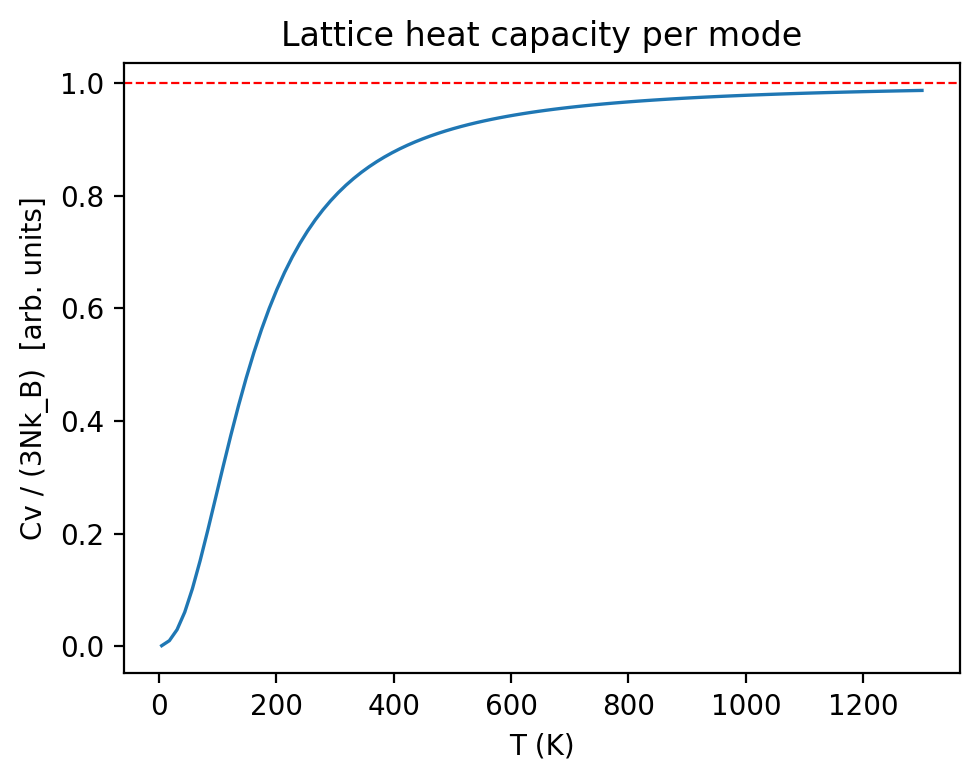

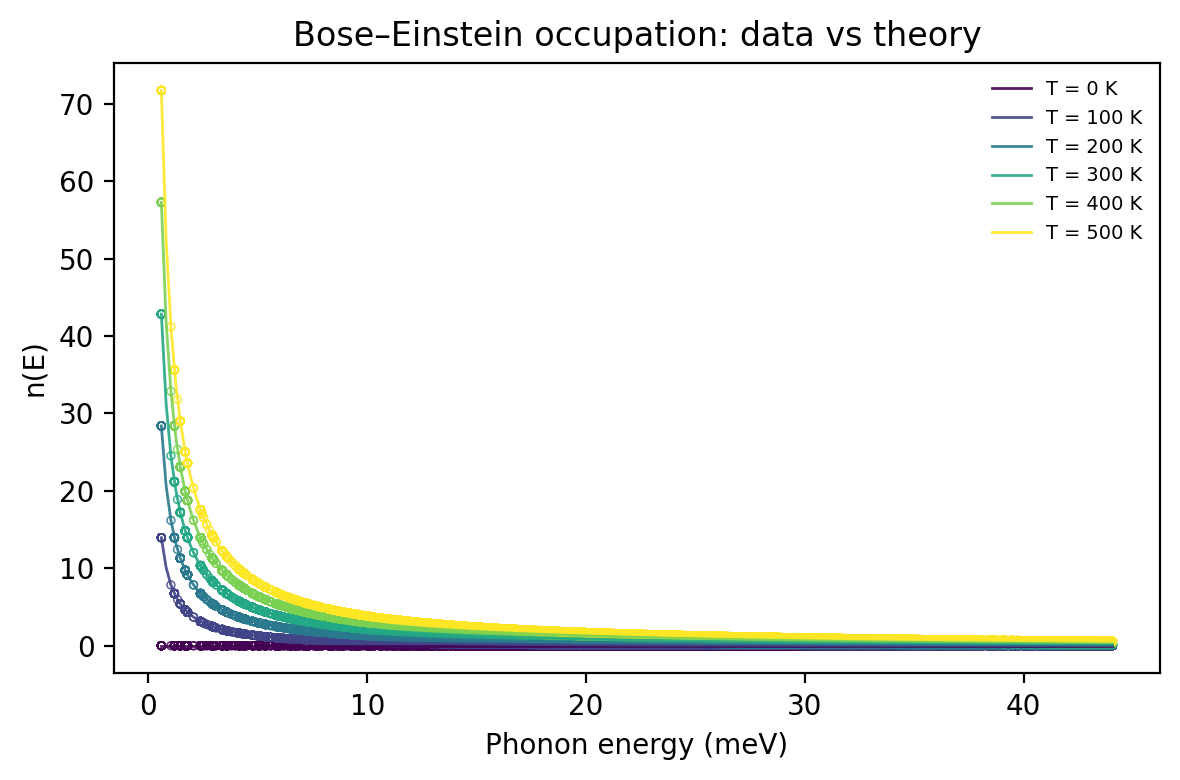

In [24]:
from sklearn import linear_model  # (used elsewhere, keep import if notebook shares context)

def build_phonon_vector(id_band,extractQ = False):
    if(extractQ): Q = []
    phonon = []
    for i in range(n_kp):
        for j in range(n_k):
            if(extractQ): Q.append(kIBZ[j] - kFBZ[i])
            phonon.append(phonon_eigen[i,j,id_band])
    if(extractQ):
        return np.array(Q),np.array(phonon)
    else:
        return np.array(phonon)

phonon_vec = np.array([build_phonon_vector(i) for i in range(nBand_ph)])
Q,trash = build_phonon_vector(0,True)


print(np.max(phonon_vec))

# helper: snap q-points to unique values (to clean duplicates due to numerical noise)
Q_round = np.round(Q, decimals=6)
Q_u, idx = np.unique(Q_round, axis=0, return_index=True)  # unique q-points
print("unique q-points:", Q_u.shape)

# phonon_vec[band][q_index] -> frequency at mode 'band' and point 'q_index'
# reduce that to only unique q-points
phonon_u = np.array([phonon_vec[i][idx] for i in range(nBand_ph)])

# Thermodynamics from phonon modes
# flatten all mode frequencies across q
phonon_u = np.hstack(phonon_u)
print("phonon_u shape:", phonon_u.shape)

# sort them (useful for DOS-like inspection)
id_sort = np.argsort(phonon_u)
phonon_u = phonon_u[id_sort]

# interpret phonon frequencies:
# is_omega = True  means data are already angular frequencies ω in (2π THz) numeric units
# is_omega = False means data are plain frequencies f in THz, and we must convert to ω = 2π f
is_omega = True
n_modes  = phonon_u.size  # total number of modes in cell
print("n_modes =", n_modes)

# constants
hbar_meVs      = 6.582119569e-13   # ħ in meV·s
kB_meV_perK    = 8.617333262e-2    # k_B in meV/K

# convert phonon_u -> angular frequency ω [s^-1]
if is_omega:
    # phonon_u is already ω / (2π THz units) -> multiply by 1e12 to get s^-1
    omega = phonon_u * 1e12
else:
    # phonon_u is f in THz -> ω = 2π f
    omega = 2 * np.pi * phonon_u * 1e12

# per-mode energies in meV
E_mode_meV = hbar_meVs * omega  # ħ ω

# zero-point energy
E_zp_total_meV = 0.5 * np.sum(E_mode_meV)
print("Zero-point energy per cell [meV]:", E_zp_total_meV)

def Cv_from_modes(omega, temps):
    """
    Heat capacity Cv(T) from harmonic phonons.
    temps: array of temperatures [K]
    returns: Cv_meV_perK per cell (sum over modes)
    """
    hbar = hbar_meVs
    kB   = kB_meV_perK
    Cv_meV_perK = np.zeros_like(temps, dtype=float)

    for i, T in enumerate(temps):
        beta = 1.0 / (kB * T)
        x = beta * hbar * omega  # dimensionless
        # numerical safety
        x = np.clip(x, 1e-12, 1e3)
        ex = np.exp(x)
        cv_modes = (x**2) * ex / (ex - 1.0)**2
        Cv_meV_perK[i] = np.sum(cv_modes)
    return Cv_meV_perK

temps = np.linspace(5, 1300, 100)  # K
Cv_meV_perK = Cv_from_modes(omega, temps)

# normalize by number of modes to compare vs Dulong-Petit limit
plt.figure(figsize=(5,4), dpi=200)
plt.plot(temps, Cv_meV_perK / n_modes, lw=1.2)
plt.axhline(1.0, color="red", ls="--", lw=0.8)  # classical high-T limit ~ k_B per mode
plt.ylabel("Cv / (3Nk_B)  [arb. units]")
plt.xlabel("T (K)")
plt.title("Lattice heat capacity per mode")
plt.tight_layout()
plt.show()


# Bose–Einstein occupation n(E,T)
# E_meV : phonon energy in meV
def BE(T, E_meV):
    if T == 0:
        return 0.0
    # convert meV -> Joule
    E_J = E_meV * 1e-3 * scipy.constants.e  # meV -> eV -> J
    kBT = scipy.constants.k * T             # J
    x = E_J / kBT
    x = np.clip(x, 1e-8, 1e3)
    return 1.0 / (np.exp(x) - 1.0)

# factor to convert your phonon eigenvalues to meV
# phonon_eigen[j,i,0] * c -> energy in meV
c = scipy.constants.hbar * 1e12 / scipy.constants.e * 1e3

temps = np.arange(0, 600, 100)  # K
# colormap across temperatures to keep things readable
cmap = plt.cm.viridis
colors = [cmap(n / max(temps)) for n in temps]

plt.figure(figsize=(6,4), dpi=200)

for T, col in zip(temps, colors):

    # 1. empirical data: sample n_w(T,E) from the phonon population
    Eph = []  # energies [meV]
    n_w = []  # occupations
    for i in range(len(kIBZ)):
        for j in range(len(kFBZ)):
            E_meV = phonon_eigen[j, i, 0] * c
            Eph.append(E_meV)
            n_w.append(BE(T, E_meV))

    Eph = np.array(Eph)
    n_w = np.array(n_w)

    # sort by energy so scatter doesn't zigzag
    order = np.argsort(Eph)
    Eph = Eph[order]
    n_w = n_w[order]

    # optional: ignore the very lowest ~150 entries, that are divergent!
    Eph_plot = Eph[150:]
    n_w_plot = n_w[150:]

    # empirical scatter: unfilled thin markers
    plt.scatter(
        Eph_plot,
        n_w_plot,
        s=8,
        facecolors='none',
        edgecolors=col,
        linewidths=0.5,
        alpha=0.6
    )

    # 2. theoretical Bose-Einstein curve at same T
    # smooth energy grid spanning observed range
    E_theory = np.linspace(Eph_plot.min(), Eph_plot.max(), 200)
    n_theory = [BE(T, e_meV) for e_meV in E_theory]

    plt.plot(
        E_theory,
        n_theory,
        color=col,
        linewidth=1.0,
        alpha=0.9,
        label=f"T = {T} K"
    )

plt.xlabel("Phonon energy (meV)")
plt.ylabel("n(E)")
plt.title("Bose–Einstein occupation: data vs theory")
plt.legend(fontsize=7, frameon=False)
plt.tight_layout()
plt.show()

### Band Gap renorm from El-Ph matrix elements
    From VASP WIKI: /matrix_elements/elph
    shape: {nspin, n_kp, n_k, 3*natoms, nBand_kp, nBand_k, 2}
    HERE = (1   , 1728,   72,     6,        10,      6,    2)
    The last (fastest) dimension is due to complex numbers
    being stored as two real numbers (real and imaginary parts).
    n_kp and nBand_kp refer to the initial (Ket) state.
    n_k and nBand_k refer to the final (Bra) state.
    
$g_{nmv}(\vec{k_p},\vec{k}) = <m\vec{k}|\partial V_{ph}(v,\vec{k}-\vec{k_p})|n\vec{k_p}>$


In [25]:
# try to evaluate band gap renormalization at gamma point , formula 166 review Giustino
def firstOccurance(arr, vec):
    for i in range(len(arr)):
        if(np.all(arr[i]==vec)):
            return i
    return -1


def BE(T,E):
    if(T==0):
       return 0
    c = scipy.constants.e/(scipy.constants.k) #Plank divided by Boltzman costant 
    x = E*c/T
    x = np.clip(x, -700, 700)
    return 1/(np.exp(x)-1)

def FD(T,E,Ef):
    if(T==0.0):
        if(E<=Ef):
            return 1
        else:
            return 0
    c = scipy.constants.e/scipy.constants.k
    x = (E - Ef) * c / T
    # Clip to avoid overflow in exp()
    x = np.clip(x, -700, 700)
    return 1.0 / (1.0 + np.exp(x))



def computeRenormalizedBand(kp, n_band, T,Ef, delta = 0.01): #delta default is same used in vasp calculation
    index = firstOccurance(kFBZ,kp)
    dE = 0
    dEv=0
    Enkp = electron_eigen_FBZ[n_band,index] #energy of ket state
    for v in range(nBand_ph):
        for i_k in range(len(kIBZ)):
            dEv = 0   
            for m in range(nBand_k):
                g = matrix[0,index,i_k,v,n_band,m,0] + matrix[0,index,i_k,v,n_band,m,1]*1J
                f = phonon_eigen[index,i_k,v] #THz
                if(f==0): #in this case for frequency zero also g is zero
                    if(np.abs(g)!=0):
                        print("NOT ZERO ",g)
                    continue
                Eph = f*scipy.constants.hbar*1e12/(scipy.constants.e) # Phonon energy eV
                Emk = electron_eigen_IBZ[m,i_k] #Bra state energy
                dEv += np.abs(g)**2*(
                       (1-FD(T,Emk,Ef)+BE(T,Eph))/(Enkp-Emk-Eph+delta*1J)
                    + (FD(T,Emk,Ef)+BE(T,Eph))/(Enkp-Emk+Eph+delta*1J) ).real
                #dEv+= np.abs(g)**2*(1/(Enkp - Emk +delta*1J)).real*(2*BE(T,Eph)+1)
            dEv*=weights[i_k]
            dE += dEv
    
    return  dE

kp = [0,0,0]
T = np.arange(0,600,100)
n_CB = 4
n_VB = 3 #here hard coded,usually I extract it from the bands


KS = electron_eigen_FBZ[n_CB,0] - electron_eigen_FBZ[n_VB,0]
print("Direct gap")
print("KS eigen=",KS)
print("     Temperature (K)         RE fan (eV)         QP gap (eV)     KS-QP gap (meV)")
print("--------------------------------------------------------------------------------")

for T_val in T:
    dE_VB = computeRenormalizedBand(kp, n_VB, T_val, Ef)
    dE_CB = computeRenormalizedBand(kp, n_CB, T_val, Ef)
    E_CB_renormalized = electron_eigen_FBZ[n_CB,0] + dE_CB
    E_VB_renormalized = electron_eigen_FBZ[n_VB,0] + dE_VB
    qp_direct_gap_at_gamma = E_CB_renormalized - E_VB_renormalized
    
    ks_qp_difference_meV = (KS - qp_direct_gap_at_gamma) * 1000.0
    
    print(f"VB{T_val:16.6f} {dE_VB:18.6f} {qp_direct_gap_at_gamma:18.6f} {ks_qp_difference_meV:18.6f}")
    print(f"CB{0:16.6f} {dE_CB:18.6f} {0:18.6f} {0:18.6f}\n")






Direct gap
KS eigen= 2.646896182096598
     Temperature (K)         RE fan (eV)         QP gap (eV)     KS-QP gap (meV)
--------------------------------------------------------------------------------
VB        0.000000           0.141611           2.465190         181.706433
CB        0.000000          -0.040095           0.000000           0.000000

VB      100.000000           0.005505           2.603776          43.120176
CB        0.000000          -0.037615           0.000000           0.000000

VB      200.000000          -0.153274           2.766174        -119.277636
CB        0.000000          -0.033996           0.000000           0.000000

VB      300.000000          -0.306891           2.924236        -277.339330
CB        0.000000          -0.029551           0.000000           0.000000

VB      400.000000          -0.457329           3.079375        -432.479274
CB        0.000000          -0.024850           0.000000           0.000000

VB      500.000000          -0.606